In [34]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error

companies = pd.read_csv('sp500_companies.csv')
index = pd.read_csv('sp500_index.csv')

# Displaying the first few rows of each dataset to understand their structure
companies_head = companies.head()
index_head = index.head()

(companies_head, index_head)

(  Exchange Symbol              Shortname               Longname  \
 0      NMS   MSFT  Microsoft Corporation  Microsoft Corporation   
 1      NMS   AAPL             Apple Inc.             Apple Inc.   
 2      NMS   NVDA     NVIDIA Corporation     NVIDIA Corporation   
 3      NMS   AMZN       Amazon.com, Inc.       Amazon.com, Inc.   
 4      NMS   GOOG          Alphabet Inc.          Alphabet Inc.   
 
                    Sector                        Industry  Currentprice  \
 0              Technology       Software - Infrastructure        425.52   
 1              Technology            Consumer Electronics        169.58   
 2              Technology                  Semiconductors        880.08   
 3       Consumer Cyclical                 Internet Retail        185.07   
 4  Communication Services  Internet Content & Information        153.94   
 
        Marketcap        Ebitda  Revenuegrowth           City State  \
 0  3161800835072  1.184270e+11          0.176        Redmond

## Preperation

In [33]:
# Check for missing values in both datasets
missing_values = {
    "sp500_companies_missing": companies.isnull().sum(),
    "sp500_index_missing": index.isnull().sum()
}

# Ensure the 'Date' column in sp500_index_df is of datetime type
index['Date'] = pd.to_datetime(index['Date'])

# Check data types of both datasets
data_types = {
    "sp500_companies_datatypes": companies.dtypes,
    "sp500_index_datatypes": index.dtypes
}

missing_values, data_types

({'sp500_companies_missing': Exchange                0
  Symbol                  0
  Shortname               0
  Longname                0
  Sector                  1
  Industry                1
  Currentprice            0
  Marketcap               0
  Ebitda                 28
  Revenuegrowth           2
  City                    0
  State                  20
  Country                 0
  Fulltimeemployees       4
  Longbusinesssummary     0
  Weight                  0
  dtype: int64,
  'sp500_index_missing': Date            0
  S&P500          0
  S&P500_lag_1    1
  S&P500_lag_2    2
  S&P500_lag_3    3
  S&P500_lag_4    4
  S&P500_lag_5    5
  dtype: int64},
 {'sp500_companies_datatypes': Exchange                object
  Symbol                  object
  Shortname               object
  Longname                object
  Sector                  object
  Industry                object
  Currentprice           float64
  Marketcap                int64
  Ebitda                 float64
  R

In [14]:
# Fill missing numeric values with median values of their respective columns
numeric_columns = ['Ebitda', 'Revenuegrowth', 'Fulltimeemployees']
companies[numeric_columns] = companies[numeric_columns].fillna(companies[numeric_columns].median())

# Fill missing categorical values with the most frequent value in their respective columns
categorical_columns = ['Sector', 'Industry', 'State']
for col in categorical_columns:
    companies[col] = companies[col].fillna(companies[col].mode()[0])

# Recheck for missing values to ensure all are addressed
missing_values_after_filling = companies.isnull().sum()

missing_values_after_filling

Exchange               0
Symbol                 0
Shortname              0
Longname               0
Sector                 0
Industry               0
Currentprice           0
Marketcap              0
Ebitda                 0
Revenuegrowth          0
City                   0
State                  0
Country                0
Fulltimeemployees      0
Longbusinesssummary    0
Weight                 0
dtype: int64

## Trends

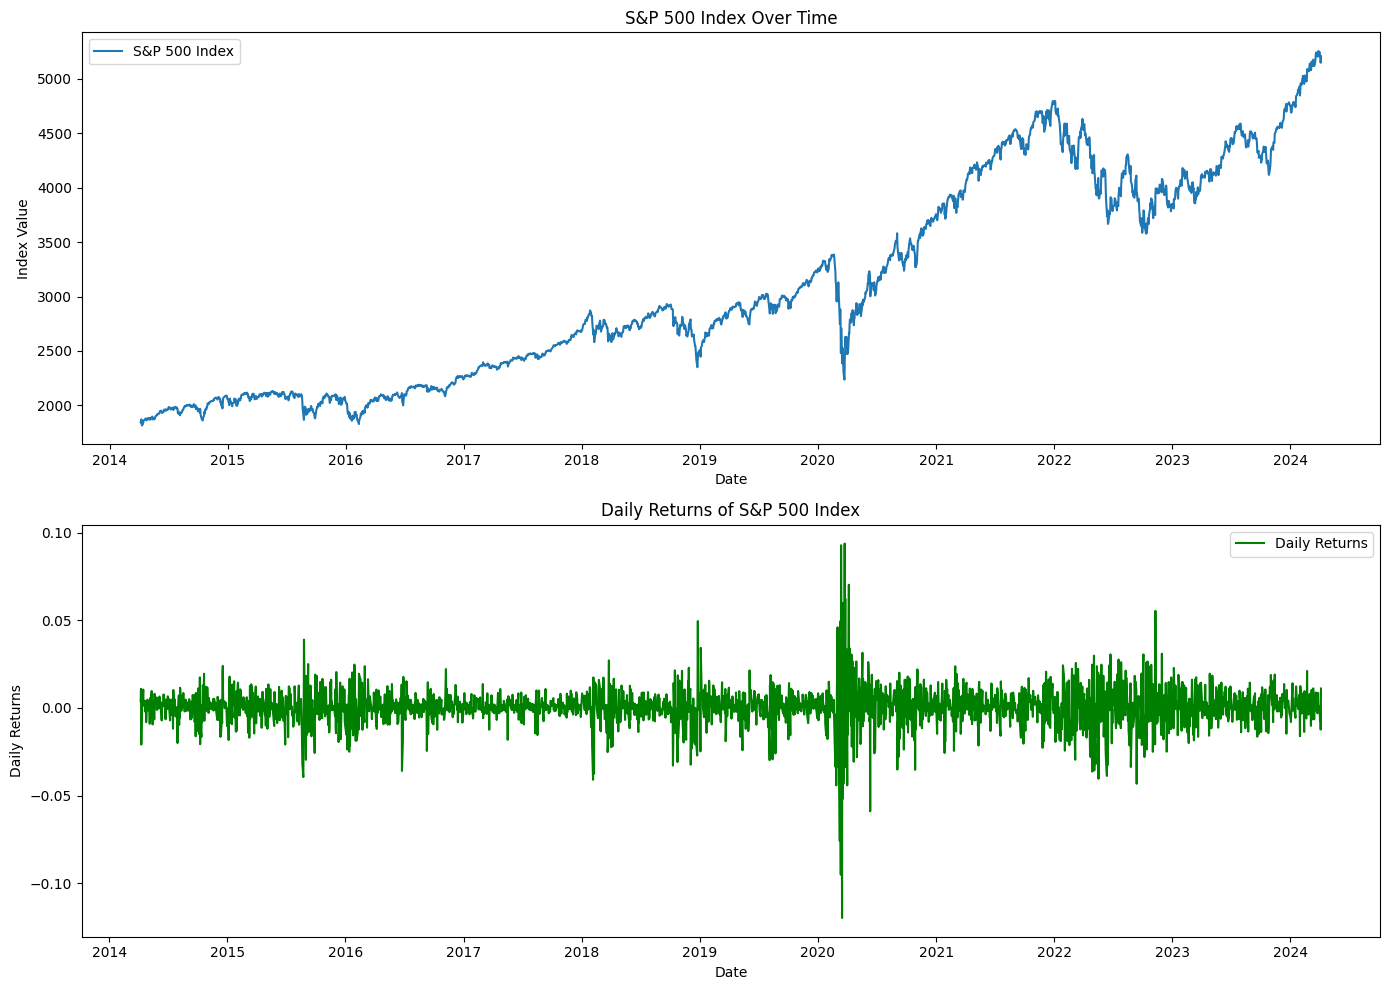

In [15]:
# Calculate daily returns of the S&P 500 index
index['Daily_Returns'] = index['S&P500'].pct_change()

# Calculate the volatility
volatility = index['Daily_Returns'].std() * np.sqrt(252) 

# Plot 
import matplotlib.pyplot as plt

fig, ax = plt.subplots(2, 1, figsize=(14, 10))

# index over time
ax[0].plot(index['Date'], index['S&P500'], label='S&P 500 Index')
ax[0].set_title('S&P 500 Index Over Time')
ax[0].set_xlabel('Date')
ax[0].set_ylabel('Index Value')
ax[0].legend()

# Daily Returns
ax[1].plot(index['Date'], index['Daily_Returns'], label='Daily Returns', color='green')
ax[1].set_title('Daily Returns of S&P 500 Index')
ax[1].set_xlabel('Date')
ax[1].set_ylabel('Daily Returns')
ax[1].legend()

plt.tight_layout()
plt.show()


## Modeling

In [32]:
# Create lagged features for the S&P 500 index
for lag in range(1, 6):  
    index[f'S&P500_lag_{lag}'] = index['S&P500'].shift(lag)

# Drop the initial rows with NaN values due to lagging
index_clean = index.dropna()

# Define features and target
features = [f'S&P500_lag_{lag}' for lag in range(1, 6)]
target = 'S&P500'

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(index_clean[features], index_clean[target], test_size=0.3, shuffle=False)

# linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Predictions
predictions = model.predict(X_test)

# Evaluate the model
mae = mean_absolute_error(y_test, predictions)
rmse = np.sqrt(mean_squared_error(y_test, predictions))

print(predictions[:5])

print(mae)
print(rmse)

[4078.68943203 4092.3136598  4128.15509015 4134.33567945 4140.98773545]
35.587864072914044
46.97501171852202


## High Low

In [23]:
# Identify top 5 high performance and bottom 5 low performance stocks
top_5 = companies.nlargest(5, 'Return')[['Symbol', 'Shortname', 'Sector', 'Return']]
bottom_5 = companies.nsmallest(5, 'Return')[['Symbol', 'Shortname', 'Sector', 'Return']]

print(top_5)
print()
print(bottom_5)

    Symbol                        Shortname              Sector    Return
475   CTLT                   Catalent, Inc.          Healthcare  0.197186
390    BBY               Best Buy Co., Inc.   Consumer Cyclical  0.196202
261    PPG             PPG Industries, Inc.     Basic Materials  0.196022
69      GS  Goldman Sachs Group, Inc. (The)  Financial Services  0.194755
441    CPB            Campbell Soup Company  Consumer Defensive  0.194656

    Symbol                        Shortname              Sector    Return
208    PCG       Pacific Gas & Electric Co.           Utilities -0.197975
72    SCHW  Charles Schwab Corporation (The  Financial Services -0.197791
128     CL        Colgate-Palmolive Company  Consumer Defensive -0.197219
205    AEP  American Electric Power Company           Utilities -0.196321
407    ESS       Essex Property Trust, Inc.         Real Estate -0.195665
